## Notes on features to choose:

### From Kaggle:
#### Extensive Sberbank Exploratory Analysis:
**source:** https://www.kaggle.com/captcalculator/a-very-extensive-sberbank-exploratory-analysis
* 37 observations where life_sq is greater than full_sq.
* A vast majority of the apartments have three rooms or less.
* look to see how life sq ~ price changes based on sub-area or distance to kremlin
* Home price does seem to increase with population density.
* There does not appear to be a relationship between the mean home price in a district and the district’s share of working age population.
* Surprisingly, there is little to no correlation between price and the school variables. The school variables however are highly correlated with each other, indicating that we would not want to use all of them in a linear regression model due to multicollinearity.
* homes with >3 top 20 universities show signs of correlation, but only one house fits that description.
* raions that have a top 25 cultural object have a median home sale price that is higher by 1.2 million (using this feature as a factor)
* strong positive correlation between sport_objects_raion and price_doc

#### Simple Exploration Notebook - Sberbank
**source:** https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-sberbank

* overall increasing trend in price as floor_num increases. A sudden increase in the house price is also observed at floor 18.
* Individual houses seems to be costlier, check price of 0 floor houses.

#### Map visualizations with external shapefile
**source:** https://www.kaggle.com/jtremoureux/map-visualizations-with-external-shapefile/notebook



### Things to Consider/Reminders:
* housing market is influenced by the economy, but regions can become "hot" leading to overpriced properties.
* find or create one feature for every type of measurement that a set of similar features is representing (ie. one feature/meta-feature for location, one for size of unit, etc.) 

### Pipeline To Do:
* Look into kriging regression model for geospatial features
* Plot price to gender/age/subregion.
* subregions
    * linear reg to predict price just with subregion and size
    * mean/sd/var/median. 
    * see how well you can predict the sub-region by using price and size of home as features. 
    * max floors vs. price per subregion

### Import Libraries & Data

In [131]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="ticks", palette="muted", color_codes=True)

In [132]:
# load dataset
df = pd.read_csv("./robust_scaled_df_2017-05-28.csv", parse_dates=['timestamp'], index_col=False, low_memory=False)

# train_df = pd.read_csv("./May27_dtrain.csv", parse_dates=['timestamp'], index_col=False, low_memory=False)
# test_df = pd.read_csv("./May27_dtest.csv", parse_dates=['timestamp'], index_col=False, low_memory=False)


# [column in list(test_df.columns)  for column in train_df.columns]

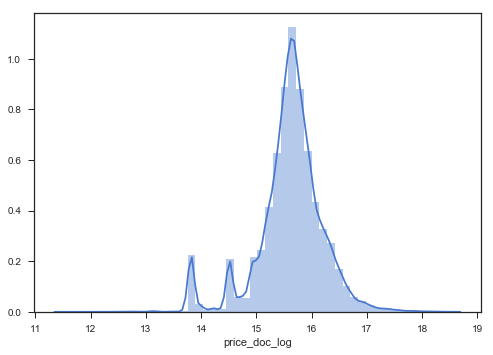

In [133]:
import seaborn as sns


# sns.distplot(df['build_year'].dropna())
# sns.distplot(np.log(df['build_year']).dropna())
sns.distplot(df['price_doc_log'].dropna())
# df[['build_year','state']].dropna().corr().plot()

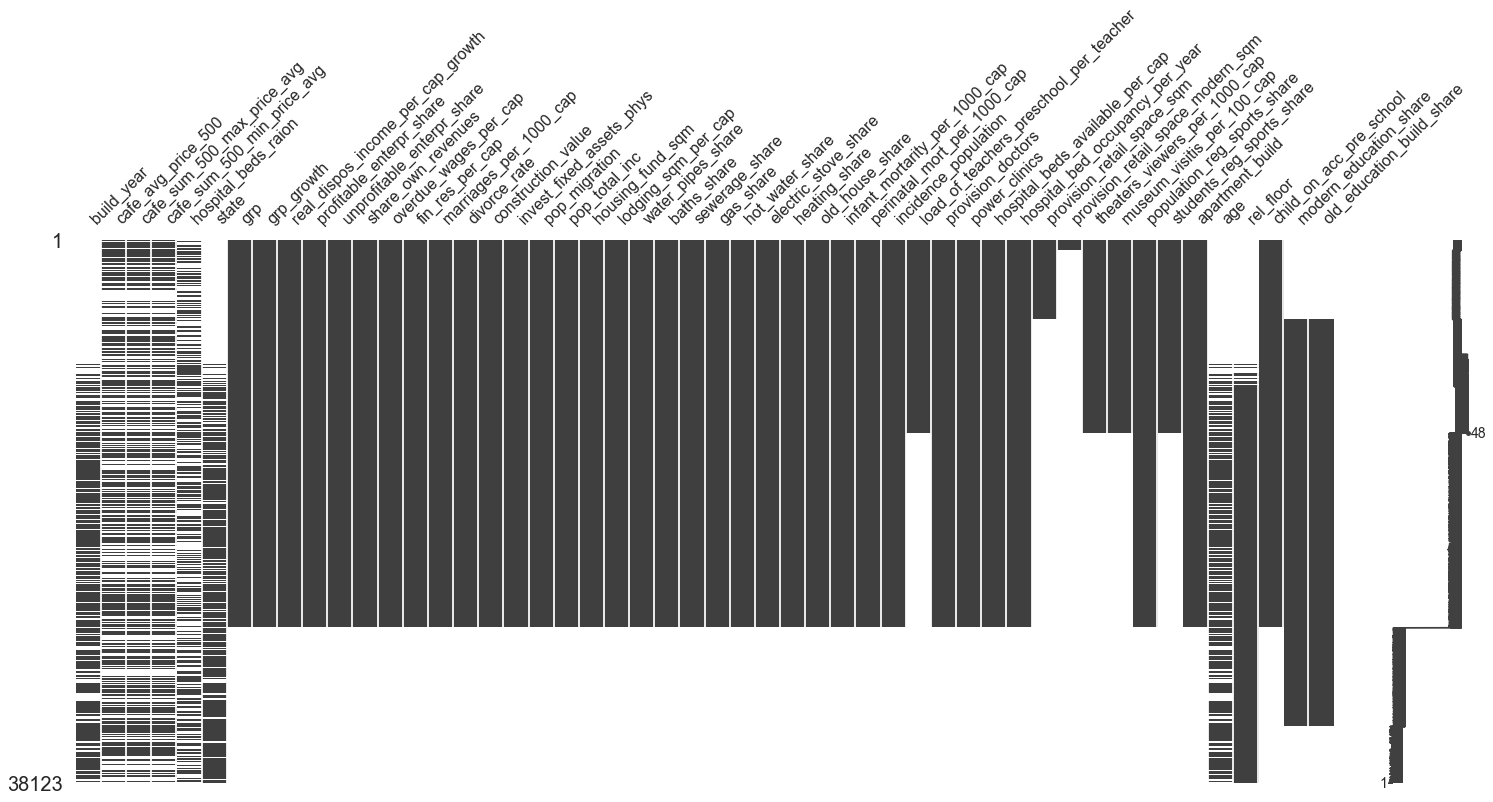

In [134]:
import missingno as msno

df.set_index('timestamp')
filtered_data = msno.nullity_filter(df, filter='bottom', n=50, p=0.99) # or filter='top'

msno.missingno.matrix(filtered_data)

In [135]:
df['age'].describe()

count    22017.000000
mean        28.241859
std         20.990004
min          0.000000
25%          7.000000
50%         32.000000
75%         46.000000
max        155.000000
Name: age, dtype: float64

## Build Year

Build year has about 1/3 of it's data missing. With it's strong feature importance in a variety of different models, we decided to try and find a way to regress against build_year to predict the missing values. 


In [136]:
df['build_year'].describe()
# df['state'].describe()

count    22017.000000
mean      1986.261707
std         21.205320
min       1860.000000
25%       1969.000000
50%       1983.000000
75%       2008.000000
max       2019.000000
Name: build_year, dtype: float64

#### Convert categorical featuers to factors

In [137]:
from sklearn import preprocessing

for feature in df.columns:
    if df[feature].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df[feature].values)) 
        df[feature] = lbl.transform(list(df[feature].values))


In [138]:
# Considering the predictors having high or some correlation with price_doc (from EDA)

vars_subset = ['full_sqrt', 'life_sq^2', 'floor', 'area_km', 'density',
               'max_floor', 'material', 'num_room', 'area_m', 'age','work_share',
               'kitch_sq', 'state', 'product_type', 'sub_area', 'indust_part', 'sport_objects_raion',
               'oil_chemistry_raion', 'metro_min_avto', 'green_zone_km', 'industrial_km', 'kremlin_km',
               'radiation_km', 'ts_km', 'fitness_km', 'stadium_km', 'trc_sqm_5000', 'park_km']

df_subset = df[vars_subset]

**Split the data into a train/test set, with the test set being the observations where age are missing.**

In [139]:
y_train = df_subset.loc[df_subset['age'].notnull(), 'age']
X_train = df_subset.loc[df_subset['age'].notnull(), df_subset.columns != 'age']
X_test = df_subset.loc[df_subset['age'].isnull(), df_subset.columns != 'age']

print y_train.shape, X_train.shape, X_test.shape

(22017,) (22017, 27) (16106, 27)


In [140]:
import xgboost as xgb

# hyperparameters
xgb_params = {
    'eta': 0.02,
    'max_depth': 5,
    'subsample': .8,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0
}

#Initialize Model
xgb_reg = XGBRegressor()

In [141]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

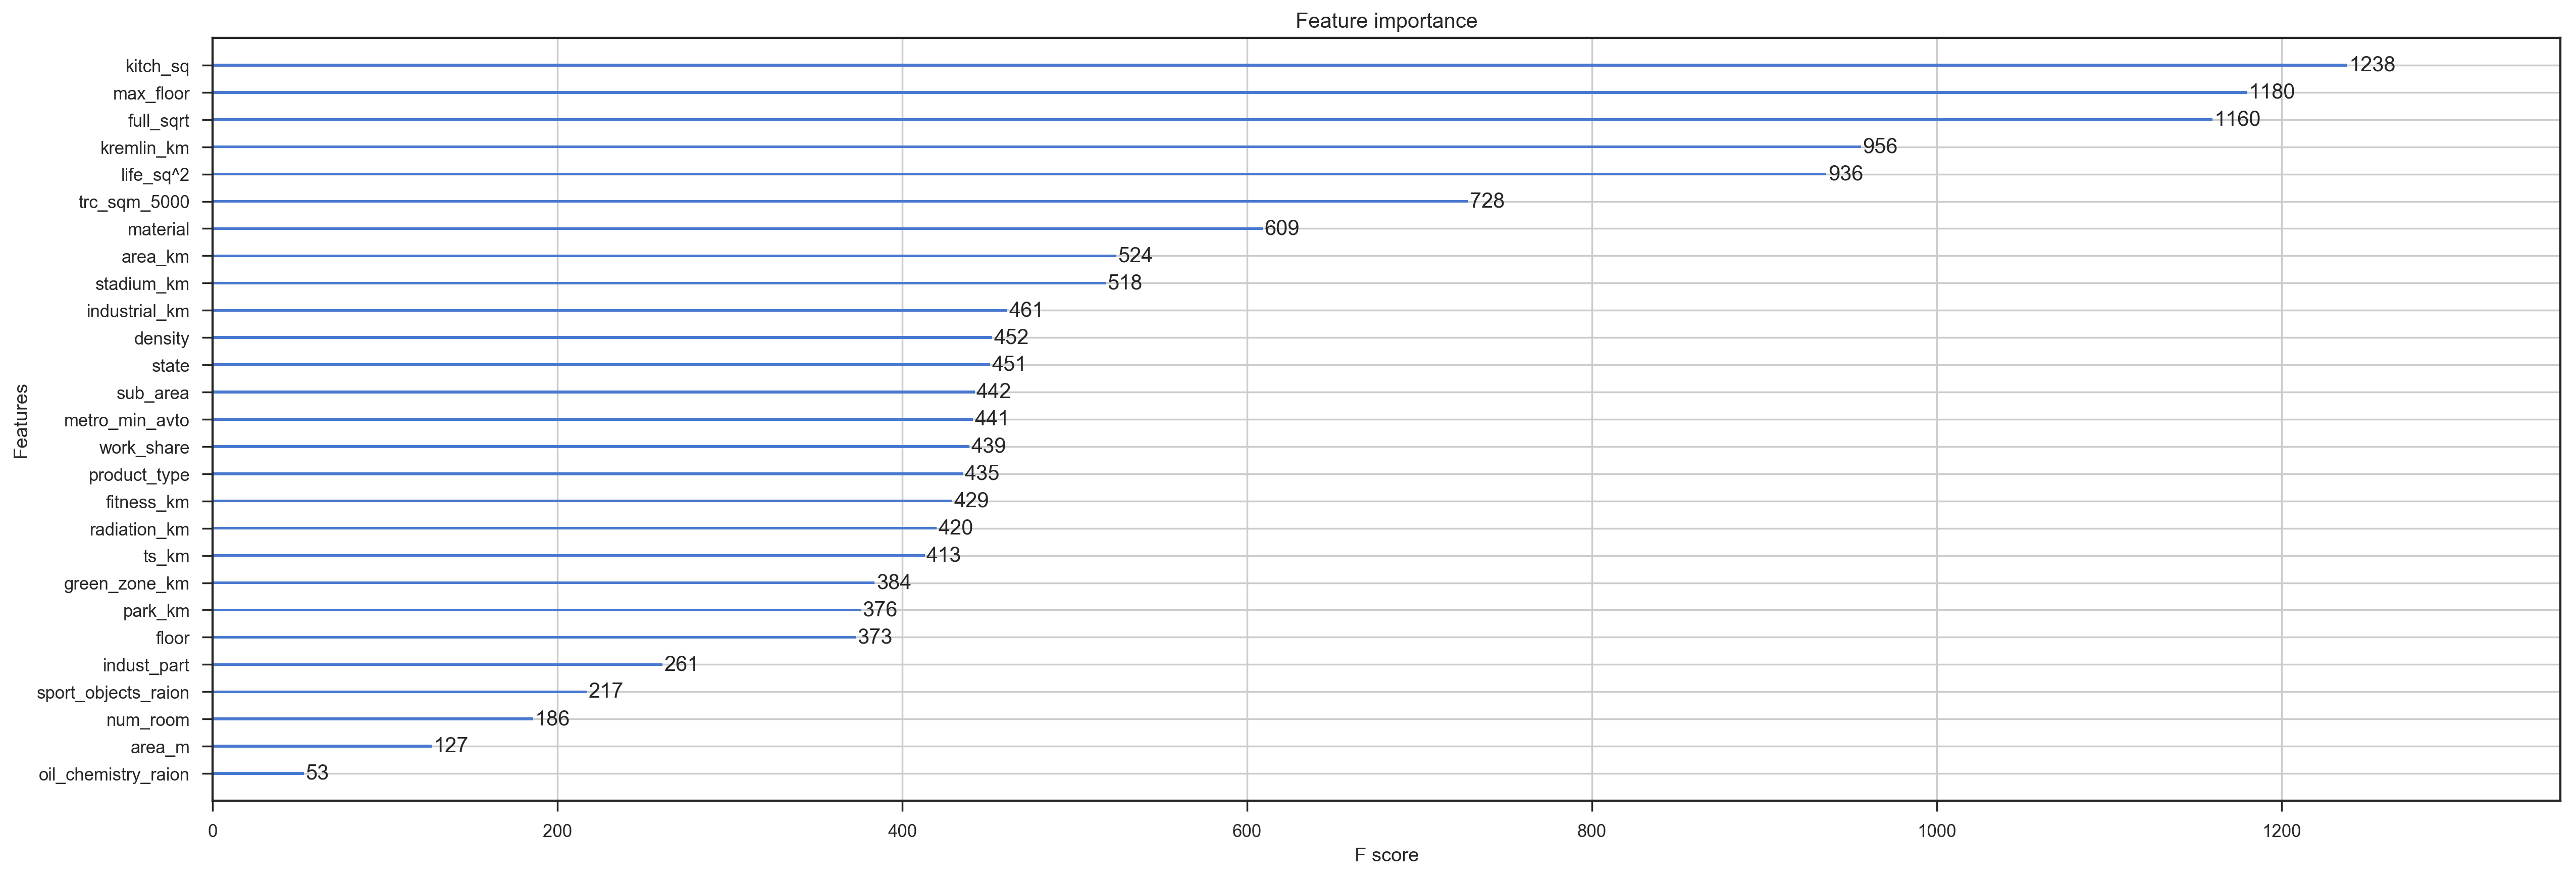

In [142]:
# plot the important features #
fig, ax = plt.subplots(figsize=(24,8), dpi=250)
xgb.plot_importance(model, height=.1, ax=ax)
plt.show()

In [143]:
np.sum(y_test < 0), np.sum(y_test > 0)

(4149, 11957)

In [144]:
y_test.max(), y_train.max()

(81.658081, 155.0)

### Impute predicted build_year values

In [145]:
df.loc[df['age'].isnull(), df.columns == 'age'] = y_test.round()

In [146]:
np.sum(df['age'].isnull())

0

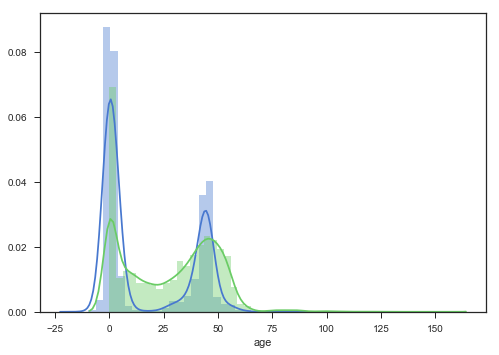

In [147]:
import seaborn as sns

sns.distplot(y_test)
sns.distplot(y_train)

In [148]:
df.loc[df['age'] < 0] = 0

In [150]:
df['timestamp']

0       2011-08-20
1       2011-08-23
2       2011-08-27
3       2011-09-01
4       2011-09-05
5       2011-09-06
6       2011-09-08
7       2011-09-09
8       2011-09-10
9       2011-09-13
10      2011-09-16
11      2011-09-16
12      2011-09-17
13      2011-09-19
14      2011-09-19
15      2011-09-20
16      2011-09-20
17      2011-09-20
18      2011-09-22
19      2011-09-22
20      2011-09-22
21      2011-09-22
22      2011-09-23
23      2011-09-23
24      2011-09-23
25      2011-09-24
26      2011-09-26
27      2011-09-26
28      2011-09-26
29      2011-09-27
           ...    
38093   2016-05-20
38094   2016-05-20
38095   2016-05-20
38096   2016-05-20
38097   2016-05-21
38098   2016-05-21
38099   2016-05-21
38100   2016-05-21
38101   2016-05-23
38102   2016-05-23
38103   2016-05-23
38104   2016-05-23
38105   2016-05-23
38106   2016-05-23
38107   2016-05-23
38108   2016-05-23
38109   2016-05-23
38110   2016-05-24
38111   2016-05-24
38112   2016-05-24
38113   2016-05-24
38114   2016

No N/A values remaining for build_year!

### Export to new data files

In [151]:
from datetime import datetime

df.loc[df['price_doc'].notnull(), :].to_csv('./train_df_build_year_{0}.csv'.format(datetime.date(datetime.now())), index=False)
df.loc[df['price_doc'].isnull(), :].to_csv('./test_df_build_year_{0}.csv'.format(datetime.date(datetime.now())), index=False)
df.to_csv('./merged_w_build_year_{0}.csv'.format(datetime.date(datetime.now())), index=False)